In [33]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

UsageError: Line magic function `%` not found.


In [34]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [35]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [36]:
data = read_text("French_2_english/fra.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [37]:
deu_eng = deu_eng[:50000,:]

In [38]:
deu_eng

array([['Go.', 'Va !'],
       ['Hi.', 'Salut !'],
       ['Hi.', 'Salut.'],
       ...,
       ['We make sake from rice.', 'On fait le saké à partir du riz.'],
       ['We may still get lucky.',
        'On pourrait encore avoir de la chance.'],
       ['We met a few weeks ago.',
        'Nous nous sommes rencontrés il y a quelques semaines.']],
      dtype='<U349')

In [39]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [40]:
deu_eng

array([['Go', 'Va '],
       ['Hi', 'Salut '],
       ['Hi', 'Salut'],
       ...,
       ['We make sake from rice', 'On fait le saké à partir du riz'],
       ['We may still get lucky',
        'On pourrait encore avoir de la chance'],
       ['We met a few weeks ago',
        'Nous nous sommes rencontrés il y a quelques semaines']],
      dtype='<U349')

In [41]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [42]:
deu_eng

array([['go', 'va '],
       ['hi', 'salut '],
       ['hi', 'salut'],
       ...,
       ['we make sake from rice', 'on fait le saké à partir du riz'],
       ['we may still get lucky',
        'on pourrait encore avoir de la chance'],
       ['we met a few weeks ago',
        'nous nous sommes rencontrés il y a quelques semaines']],
      dtype='<U349')

In [43]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [44]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

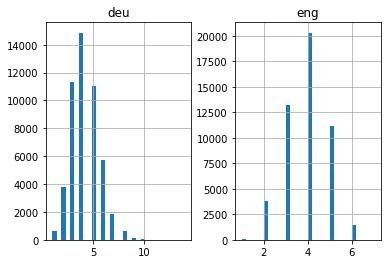

In [45]:
length_df.hist(bins = 30)
plt.show()

In [46]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [47]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6076


In [48]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('French Vocabulary Size: %d' % deu_vocab_size)

French Vocabulary Size: 14026


In [49]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

# Model building

In [50]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [51]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [52]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [53]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [54]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [55]:
filename = 'model.h1.Fre_2_Eng'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 326s 10ms/step - loss: 3.6046 - val_loss: 3.0393

Epoch 00001: val_loss improved from inf to 3.03933, saving model to model.h1.Fre_2_Eng
Epoch 2/30
32000/32000 [==============================] - 248s 8ms/step - loss: 2.9397 - val_loss: 2.8980

Epoch 00002: val_loss improved from 3.03933 to 2.89803, saving model to model.h1.Fre_2_Eng
Epoch 3/30
32000/32000 [==============================] - 241s 8ms/step - loss: 2.7832 - val_loss: 2.7559

Epoch 00003: val_loss improved from 2.89803 to 2.75590, saving model to model.h1.Fre_2_Eng
Epoch 4/30
32000/32000 [==============================] - 230s 7ms/step - loss: 2.6245 - val_loss: 2.6158

Epoch 00004: val_loss improved from 2.75590 to 2.61582, saving model to model.h1.Fre_2_Eng
Epoch 5/30
32000/32000 [==============================] - 236s 7ms/step - loss: 2.4538 - val_loss: 2.4922

Epoch 00005: val_loss improved from 2.61582 to 2.49219,

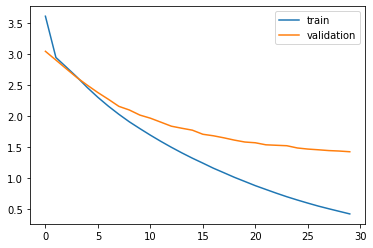

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [57]:
model = load_model('model.h1.Fre_2_Eng')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [58]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [59]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [60]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [61]:
pd.set_option('display.max_colwidth', 200)

In [62]:
pred_df.head(15)

,actual,predicted
0,i regret saying that,i said him that
1,forgive us,a
2,i did have fun,i had fun
3,bring it to me,it a
4,what did you just say,what do you told say
5,i think nobodys home,i think tom is
6,he delivers newspapers,he turned the teacher
7,my phone is vibrating,my tv is
8,do you feel lucky,do you feel lucky
9,thats the last straw,she never afford that
